## BioPAX abstraction: SIF view

> This code contains SPARQL queries allowing to abstract a BioPAX graph into SIF binary interactions.

> The abstraction rules used here are from PathwayCommons: http://www.pathwaycommons.org/pc2/formats#sif_relations 

> These rules are used in the ChiBE software to perform BioPAX to SIF translation.

#### Import librairies and launch SPARQL endpoint

In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON, CSV, N3, XML, TURTLE
import subprocess
import time
import os
from requests.utils import requote_uri
from urllib.parse import quote
import re
import rdflib
import pandas as pd

In [2]:
endpoint_reactome = "http://localhost:3030/reactome"
rdfFormat = "turtle"
current_directory = os.getcwd()
BioPAX_Ontology_file_path = os.path.join(current_directory, '../..', 'ReactomeData', 'biopax-level3.owl')
ReactomeBioPAX_file_path = os.path.join(current_directory, '../..', 'ReactomeData', 'Homo_sapiens.owl')
TestReactomeFile_path = os.path.join(current_directory, '../..', 'ReactomeData/SynthesisOf5-eicosatetraenoicAcids', 'R-HSA-2142688_level3.owl')
TestReactomeFile_path2 = os.path.join(current_directory, '../..', 'ReactomeData/TGFB', 'R-HSA-2173789_level3.owl')

In [3]:
def extract_prefix_mappings(prefixes_string):
    """
    Extract prefix mappings from the SPARQL prefixes string.
    
    Parameters:
    prefixes_string (str): String containing PREFIX declarations
    
    Returns:
    dict: Mapping of full URIs to their prefixes
    """
    # Extract prefix declarations using regex
    prefix_pattern = re.compile(r'PREFIX\s+(\w+):\s*<([^>]+)>', re.IGNORECASE)
    return {uri: prefix for prefix, uri in prefix_pattern.findall(prefixes_string)}

def convert_to_prefixed_uri(uri_string, prefix_mappings):
    """
    Convert a full URI to prefixed format.
    
    Parameters:
    uri_string (str): Full URI string
    prefix_mappings (dict): Mapping of URIs to prefixes
    
    Returns:
    str: URI in prefixed format (e.g., 'reactome:Protein')
    """
    for uri_base, prefix in prefix_mappings.items():
        if uri_string.startswith(uri_base):
            local_part = uri_string[len(uri_base):]
            return f"{prefix}:{local_part}"
    return uri_string  # Return original if no prefix matches

def save_for_cytoscape(sparql, prefixes_string, output_file, format='csv', separator=','):
    """
    Save SPARQL CONSTRUCT results in a format compatible with Cytoscape,
    using prefix notation for URIs.
    
    Parameters:
    sparql (SPARQLWrapper): Configured SPARQLWrapper instance with query
    prefixes_string (str): String containing PREFIX declarations
    output_file (str): Path to save the output file
    format (str): Output format ('csv' or 'tsv')
    separator (str): Column separator (',' for CSV, '\t' for TSV)
    """
    # Extract prefix mappings
    prefix_mappings = extract_prefix_mappings(prefixes_string)
    
    # Get the results as an RDF graph
    sparql.setReturnFormat(TURTLE)
    results = sparql.queryAndConvert()
    
    # Create an RDFlib graph
    g = rdflib.Graph()
    if isinstance(results, bytes):
        g.parse(data=results.decode('utf-8'), format='turtle')
    else:
        g.parse(data=results, format='turtle')
    
    # Convert triples to a list of dictionaries with prefixed URIs
    triples_data = []
    for s, p, o in g:# Extraction of "Signaling by EGFR" (R-HSA-177929) pathway from Reactome BioPAX export v65
        # Convert each URI to prefixed format
        subject = convert_to_prefixed_uri(str(s), prefix_mappings)
        predicate = convert_to_prefixed_uri(str(p), prefix_mappings)
        object_ = convert_to_prefixed_uri(str(o), prefix_mappings)
        
        triples_data.append({
            'Source': subject,
            'Interaction': predicate,
            'Target': object_
        })
    
    # Convert to DataFrame for easy CSV/TSV export
    df = pd.DataFrame(triples_data)
    
    # Save to file
    if format == 'csv':
        df.to_csv(output_file, index=False, sep=',')
    else:  # tsv
        df.to_csv(output_file, index=False, sep='\t')
    
    print(f"Saved {len(triples_data)} interactions to {output_file}")
    return df

def preview_network_data(df, n=5):
    """
    Preview the network data before importing into Cytoscape.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing the network data
    n (int): Number of rows to preview
    """
    print(f"\nPreview of network data ({len(df)} total interactions):")
    print(f"\nFirst {n} interactions:")
    print(df.head(n))
    
    # Print some basic network statistics
    unique_nodes = set(df['Source'].unique()) | set(df['Target'].unique())
    print(f"\nNetwork statistics:")
    print(f"Number of unique nodes: {len(unique_nodes)}")
    print(f"Number of interactions: {len(df)}")
    print(f"Unique interaction types:")
    for interaction in sorted(df['Interaction'].unique()):
        print(f"  - {interaction}")

In [4]:
reactomeVersion = 91
prefixes = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX chebi: <http://purl.obolibrary.org/obo/chebi/>
PREFIX chebidb: <http://purl.obolibrary.org/obo/CHEBI_>
PREFIX chebirel: <http://purl.obolibrary.org/obo/CHEBI#>
PREFIX oboInOwl: <http://www.geneontology.org/formats/oboInOwl#>
PREFIX bp3: <http://www.biopax.org/release/biopax-level3.owl#>
PREFIX reactome: <http://www.reactome.org/biopax/90/2173789#>
PREFIX abstraction:<http://abstraction/#>
""".format(reactomeVersion)

biopaxURI = "http://www.biopax.org/release/biopax-level3.owl#"

In [5]:
command = [
    '/home/cbeust/Softwares/JenaFuseki/apache-jena-fuseki-4.9.0/fuseki-server',
    '--file', ReactomeBioPAX_file_path,
    '--file', BioPAX_Ontology_file_path,
    '/reactome']

process = subprocess.Popen(command)
time.sleep(60)

16:03:22 INFO  Server          :: Dataset: in-memory: load file: /home/cbeust/Projects/2025/BioPAXAbstraction/01_SIFAbstraction/Scripts/../../ReactomeData/Homo_sapiens.owl
16:03:23 WARN  riot            :: [line: 67054, col: 52] {W137} Input is large. Switching off checking for illegal reuse of rdf:ID's.
16:03:45 INFO  Server          :: Dataset: in-memory: load file: /home/cbeust/Projects/2025/BioPAXAbstraction/01_SIFAbstraction/Scripts/../../ReactomeData/biopax-level3.owl
16:03:45 INFO  Server          :: Running in read-only mode for /reactome
16:03:45 INFO  Server          :: Apache Jena Fuseki 4.9.0
16:03:45 INFO  Config          :: FUSEKI_HOME=/home/cbeust/Softwares/JenaFuseki/apache-jena-fuseki-4.9.0
16:03:45 INFO  Config          :: FUSEKI_BASE=/home/cbeust/Projects/2025/BioPAXAbstraction/01_SIFAbstraction/Scripts/run
16:03:45 INFO  Config          :: Shiro file: file:///home/cbeust/Projects/2025/BioPAXAbstraction/01_SIFAbstraction/Scripts/run/shiro.ini
16:03:46 INFO  Server   

## Translation of SIF abstraction rules in SPARQL queries

#### 1 - Controls State Change Of
First protein controls a reaction that changes the state of the second protein

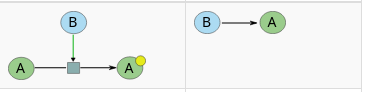

In [6]:
query_controls_state_change_of = """ 
CONSTRUCT {
  ?controllingEntityProtein abstraction:ControlsStateChangeOf ?leftProtein
}
WHERE { 
  # Core reaction pattern
  ?br rdf:type bp3:BiochemicalReaction .
  ?br bp3:left ?left .
  ?br bp3:right ?right .
  ?control (rdf:type/rdfs:subClassOf*) bp3:Control .
  ?control bp3:controlled ?br .
  ?control bp3:controller ?controllingEntity .
  
  # Handle left participant
  {
    # Case 1: Left is a Complex
    {
      ?left rdf:type bp3:Complex .
      ?left (bp3:component+|bp3:memberPhysicalEntity+)* ?leftCompo .
      ?leftCompo rdf:type bp3:Protein .
      BIND (?leftCompo AS ?leftProtein)
    }
    UNION 
    # Case 2: Left is a Protein
    {
      ?left rdf:type bp3:Protein .
      BIND (?left AS ?leftProtein)
    }
    ?leftProtein bp3:displayName ?leftProteinName .
    ?leftProtein bp3:entityReference ?leftProteinRef .
  }

  # Handle right participant (must be phosphorylated)
  {
    # Case 1: Right is a Complex
    {
      ?right rdf:type bp3:Complex .
      ?right (bp3:component+|bp3:memberPhysicalEntity+)* ?rightCompo .
      ?rightCompo rdf:type bp3:Protein .
      BIND (?rightCompo AS ?rightProtein)
    }
    UNION 
    # Case 2: Right is a Protein
    {
      ?right rdf:type bp3:Protein .
      BIND (?right AS ?rightProtein)
    }
    ?rightProtein bp3:displayName ?rightProteinName .
    # Complete modification check
    ?rightProtein bp3:feature ?feature .
    ?feature (rdf:type/rdfs:subClassOf*) bp3:EntityFeature .
    ?rightProtein bp3:entityReference ?rightProteinRef .
  }

  # Handle controlling entity
  {
    # Case 1: Controlling entity is a Complex
    {
      ?controllingEntity rdf:type bp3:Complex .
      ?controllingEntity (bp3:component+|bp3:memberPhysicalEntity+)* ?controllingEntityCompo .
      ?controllingEntityCompo rdf:type bp3:Protein .
      BIND (?controllingEntityCompo AS ?controllingEntityProtein)
    }
    UNION 
    # Case 2: Controlling entity is a Protein
    {
      ?controllingEntity rdf:type bp3:Protein .
      {
        # Try to find member proteins if they exist
        ?controllingEntity bp3:memberPhysicalEntity+ ?controllingEntityCompo .
        ?controllingEntityCompo rdf:type bp3:Protein .
        BIND (?controllingEntityCompo AS ?controllingEntityProtein)
      }
      UNION
      # If no member proteins, use the controlling entity itself
      {
        FILTER NOT EXISTS { ?controllingEntity bp3:memberPhysicalEntity ?any }
        BIND (?controllingEntity AS ?controllingEntityProtein)
      }
    }
    ?controllingEntityProtein bp3:displayName ?controllingEntityProteinName .
  }
  
  # Ensure left and right proteins are the same (unphosphorylated vs phosphorylated)
  FILTER(?leftProteinRef = ?rightProteinRef)
}
"""


# execute SPARQL query
sparql = SPARQLWrapper(endpoint_reactome)
sparql.setQuery(prefixes+query_controls_state_change_of)
df = save_for_cytoscape(sparql, prefixes, "../Results/ControlsStateChangeOf.csv", format='csv')
preview_network_data(df)

16:06:09 INFO  Fuseki          :: [4] GET http://localhost:3030/reactome?query=%0APREFIX+rdf%3A+%3Chttp%3A//www.w3.org/1999/02/22-rdf-syntax-ns%23%3E%0APREFIX+rdfs%3A%3Chttp%3A//www.w3.org/2000/01/rdf-schema%23%3E%0APREFIX+owl%3A+%3Chttp%3A//www.w3.org/2002/07/owl%23%3E%0APREFIX+xsd%3A+%3Chttp%3A//www.w3.org/2001/XMLSchema%23%3E%0APREFIX+dc%3A+%3Chttp%3A//purl.org/dc/elements/1.1/%3E%0APREFIX+dcterms%3A+%3Chttp%3A//purl.org/dc/terms/%3E%0APREFIX+chebi%3A+%3Chttp%3A//purl.obolibrary.org/obo/chebi/%3E%0APREFIX+chebidb%3A+%3Chttp%3A//purl.obolibrary.org/obo/CHEBI_%3E%0APREFIX+chebirel%3A+%3Chttp%3A//purl.obolibrary.org/obo/CHEBI%23%3E%0APREFIX+oboInOwl%3A+%3Chttp%3A//www.geneontology.org/formats/oboInOwl%23%3E%0APREFIX+bp3%3A+%3Chttp%3A//www.biopax.org/release/biopax-level3.owl%23%3E%0APREFIX+reactome%3A+%3Chttp%3A//www.reactome.org/biopax/90/2173789%23%3E%0APREFIX+abstraction%3A%3Chttp%3A//abstraction/%23%3E%0A+%0ACONSTRUCT+%7B%0A++%3FcontrollingEntityProtein+abstraction%3AControlsStateC

Saved 459998 interactions to ../Results/ControlsStateChangeOf.csv

Preview of network data (459998 total interactions):

First 5 interactions:
                                              Source  \
0  http://www.reactome.org/biopax/91/48887#Protei...   
1  http://www.reactome.org/biopax/91/48887#Protei...   
2  http://www.reactome.org/biopax/91/48887#Protei...   
3  http://www.reactome.org/biopax/91/48887#Protei...   
4  http://www.reactome.org/biopax/91/48887#Protei...   

                         Interaction  \
0  abstraction:ControlsStateChangeOf   
1  abstraction:ControlsStateChangeOf   
2  abstraction:ControlsStateChangeOf   
3  abstraction:ControlsStateChangeOf   
4  abstraction:ControlsStateChangeOf   

                                              Target  
0  http://www.reactome.org/biopax/91/48887#Protei...  
1  http://www.reactome.org/biopax/91/48887#Protei...  
2  http://www.reactome.org/biopax/91/48887#Protei...  
3  http://www.reactome.org/biopax/91/48887#Protei...  
4  h

#### 2 - Controls Transport Of

First protein controls a reaction that changes the cellular location of the second protein

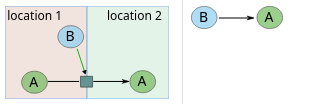

In [ ]:
query_transport_of = """
CONSTRUCT {
  ?controllingProtein abstraction:ControlsTransportOf ?Protein1Ref
}
WHERE {
  ?Protein1 rdf:type bp3:Protein ;
            bp3:displayName ?Protein1Name ;
            bp3:cellularLocation ?cellularLocVocab1 .
  ?Protein2 rdf:type bp3:SmallMolecule ;
            bp3:displayName ?Protein2Name  ;
            bp3:cellularLocation ?cellularLocVocab2 .
  
  ?Protein1 bp3:entityReference ?Protein1Ref .
  ?Protein2 bp3:entityReference ?Protein2Ref .
  ?cellularLocVocab1 bp3:term ?location1 .
  ?cellularLocVocab2 bp3:term ?location2 .

  ?biochemicalReaction rdf:type bp3:BiochemnicalReaction ;
                       bp3:left ?Protein1 ;
                       bp3:right ?Protein2 .

  ?control (rdf:type/rdfs:subClassOf*) bp3:Control .
  ?control bp3:controlled ?biochemicalReaction .
  ?control bp3:controller ?controllingEntity .
  
  {
    ?controllingEntity rdf:type bp3:Protein .
    BIND (?controllingEntity AS ?controllingProtein)
  } UNION {
    ?controllingEntity rdf:type bp3:Complex .
    ?controllingEntity (bp3:component+|bp3:memberPhysicalEntity+)* ?controllingEntityCompo .
    ?controllingEntityCompo rdf:type bp3:Protein .
    BIND (?controllingEntityCompo AS ?controllingProtein)
  } UNION {
    ?controllingEntity rdf:type bp3:PhysicalEntity .
    ?controllingEntity (bp3:memberPhysicalEntity*)/(bp3:component+|bp3:memberPhysicalEntity+)* ?controllingEntityCompo .
    ?controllingEntityCompo rdf:type bp3:Protein .
    BIND (?controllingEntityCompo AS ?controllingProtein)
  }

  FILTER (?cellularLocVocab1 != ?cellularLocVocab2)
  FILTER (?Protein1Ref = ?Protein2Ref)
}
"""

sparql = SPARQLWrapper(endpoint_reactome)
sparql.setQuery(prefixes+query_transport_of)
df = save_for_cytoscape(sparql, prefixes, "../Results/TransportOf.csv", format='csv')
preview_network_data(df)

#### 3 - Controls Phosphorylation Of

First protein controls a reaction that changes the phosphorylation status of the second protein

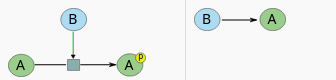

TODO : link with entityReference

In [ ]:
query_controls_phosphorylation_of = """ 
CONSTRUCT {
    ?controllingEntityProtein abstraction:controlsPhosphorylationOf ?leftProtein
    }
WHERE { 
  # Core reaction pattern
  ?br rdf:type bp3:BiochemicalReaction .
  ?br bp3:left ?left .
  ?br bp3:right ?right .
  ?control (rdf:type/rdfs:subClassOf*) bp3:Control .
  ?control bp3:controlled ?br .
  ?control bp3:controller ?controllingEntity .
  
  # Handle left participant
  {
    # Case 1: Left is a Complex
    {
      ?left rdf:type bp3:Complex .
      ?left (bp3:component+|bp3:memberPhysicalEntity+)* ?leftCompo .
      ?leftCompo rdf:type bp3:Protein .
      BIND (?leftCompo AS ?leftProtein)
    }
    UNION 
    # Case 2: Left is a Protein
    {
      ?left rdf:type bp3:Protein .
      BIND (?left AS ?leftProtein)
    }
    ?leftProtein bp3:displayName ?leftProteinName .
    ?leftProtein bp3:entityReference ?leftProteinRef .
  }

  # Handle right participant (must be phosphorylated)
  {
    # Case 1: Right is a Complex
    {
      ?right rdf:type bp3:Complex .
      ?right (bp3:component+|bp3:memberPhysicalEntity+)* ?rightCompo .
      ?rightCompo rdf:type bp3:Protein .
      BIND (?rightCompo AS ?rightProtein)
    }
    UNION 
    # Case 2: Right is a Protein
    {
      ?right rdf:type bp3:Protein .
      BIND (?right AS ?rightProtein)
    }
    ?rightProtein bp3:displayName ?rightProteinName .
    # Complete phosphorylation check
    ?rightProtein bp3:feature ?feature .
    ?feature rdf:type bp3:ModificationFeature .
    ?feature bp3:modificationType ?modificationType .
    ?modificationType rdf:type bp3:SequenceModificationVocabulary .
    ?modificationType bp3:term ?modificationTerm .
    FILTER(CONTAINS(LCASE(?modificationTerm), "phospho"))
    ?rightProtein bp3:entityReference ?rightProteinRef .
  }

  # Handle controlling entity
  {
    # Case 1: Controlling entity is a Complex
    {
      ?controllingEntity rdf:type bp3:Complex .
      ?controllingEntity (bp3:component+|bp3:memberPhysicalEntity+)* ?controllingEntityCompo .
      ?controllingEntityCompo rdf:type bp3:Protein .
      BIND (?controllingEntityCompo AS ?controllingEntityProtein)
    }
    UNION 
    # Case 2: Controlling entity is a Protein
    {
      ?controllingEntity rdf:type bp3:Protein .
      {
        # Try to find member proteins if they exist
        ?controllingEntity bp3:memberPhysicalEntity+ ?controllingEntityCompo .
        ?controllingEntityCompo rdf:type bp3:Protein .
        BIND (?controllingEntityCompo AS ?controllingEntityProtein)
      }
      UNION
      # If no member proteins, use the controlling entity itself
      {
        FILTER NOT EXISTS { ?controllingEntity bp3:memberPhysicalEntity ?any }
        BIND (?controllingEntity AS ?controllingEntityProtein)
      }
    }
    ?controllingEntityProtein bp3:displayName ?controllingEntityProteinName .
  }
  
  # Ensure left and right proteins are the same (unphosphorylated vs phosphorylated)
  FILTER(?leftProteinRef = ?rightProteinRef)
}
"""

#### 4 - Controls Expression Of
First protein controls a conversion or a template reaction that changes expression of the second protein

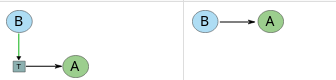

In [ ]:
query_controls_expression_of = """ 
CONSTRUCT {
  ?controllingProtein abstraction:ControlsExpressionOf ?product 
}
WHERE {
  ?tr rdf:type bp3:TemplateReaction .
  ?tr bp3:displayName ?trName .
  ?tr bp3:product ?product .
  ?product rdf:type bp3:Protein .
  ?product bp3:displayName ?productName .
  
  ?control (rdf:type/rdfs:subClassOf*) bp3:Control .
  ?control bp3:controlled ?tr .
  ?control bp3:controller ?controllingEntity .   
  
  OPTIONAL {
   ?controllingEntity rdf:type bp3:Complex .
   ?controllingEntity (bp3:component+|bp3:memberPhysicalEntity+)* ?controllingEntityCompo .
   ?controllingEntityCompo rdf:type bp3:Protein .
    BIND (?controllingEntityCompo AS ?controllingProtein)
  }
  
  OPTIONAL {
   ?controllingEntity rdf:type bp3:Protein .
   BIND (?controllingEntity AS ?controllingProtein)
  }
}
"""

#### 5 - Catalysis Precedes
Equivalent of sequential_catalysis from Paxtools SIF rules
First protein controls a conversion whose input molecule is input to another reaction controlled by a second protein 

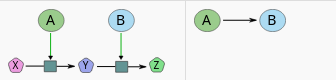

In [ ]:
query_catalysis_precedes = """ 
CONSTRUCT {
  ?controllingProtein1 abstraction:CatalysisPrecedes ?controllingProtein2  
}
WHERE {
  ?reaction1 rdf:type bp3:BiochemicalReaction .
  ?reaction1 bp3:left ?left1 .
  ?reaction1 bp3:right ?right1 .
  ?left1 rdf:type bp3:SmallMolecule .
  ?right1 rdf:type bp3:SmallMolecule .
  ?control1 (rdf:type/rdfs:subClassOf*) bp3:Control .
  ?control1 bp3:controlled ?reaction1 .
  ?control1 bp3:controller ?controllingEntity1 .
  
  # Identifier ?controllingProtein1
  {
    ?controllingEntity1 rdf:type bp3:Protein .
    BIND (?controllingEntity1 AS ?controllingProtein1)
  } UNION {
    ?controllingEntity1 rdf:type bp3:Complex .
    ?controllingEntity1 (bp3:component+|bp3:memberPhysicalEntity+)* ?controllingEntity1Compo .
    ?controllingEntity1Compo rdf:type bp3:Protein .
    BIND (?controllingEntity1Compo AS ?controllingProtein1)
  } UNION {
    ?controllingEntity1 rdf:type bp3:PhysicalEntity .
    ?controllingEntity1 (bp3:memberPhysicalEntity*)/(bp3:component+|bp3:memberPhysicalEntity+) ?controllingEntity1Compo .
    ?controllingEntity1Compo rdf:type bp3:Protein .
    BIND (?controllingEntity1Compo AS ?controllingProtein1)
  }
  
  # Identifier ?controllingProtein2
  ?reaction2 rdf:type bp3:BiochemicalReaction .
  ?reaction2 bp3:left ?right1 .
  ?reaction2 bp3:right ?right2 .
  ?right2 rdf:type bp3:SmallMolecule .
  ?control2 (rdf:type/rdfs:subClassOf*) bp3:Control .
  ?control2 bp3:controlled ?reaction2 .
  ?control2 bp3:controller ?controllingEntity2 .
  
  # Exploration complète de PhysicalEntity pour ?controllingProtein2
  {
    ?controllingEntity2 rdf:type bp3:Protein .
    BIND (?controllingEntity2 AS ?controllingProtein2)
  } UNION {
    ?controllingEntity2 rdf:type bp3:Complex .
    ?controllingEntity2 (bp3:component+|bp3:memberPhysicalEntity+)* ?controllingEntity2Compo .
    ?controllingEntity2Compo rdf:type bp3:Protein .
    BIND (?controllingEntity2Compo AS ?controllingProtein2)
  } UNION {
    ?controllingEntity2 rdf:type bp3:PhysicalEntity .
    ?controllingEntity2 (bp3:memberPhysicalEntity*)/(bp3:component+|bp3:memberPhysicalEntity+) ?controllingEntity2Compo .
    ?controllingEntity2Compo rdf:type bp3:Protein .
    BIND (?controllingEntity2Compo AS ?controllingProtein2)
  }
  
  FILTER (?controllingProtein1 != ?controllingProtein2)
}
"""

#### 6 - In Complex With
Equivalent component of Paxtools SIF rules
Proteins are members of the same complex

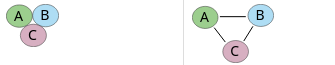

Remarks : 
- several scales of complexes : for example physical entities made of complexes 
- do we link proteins part of the same physical entity ?

In [ ]:
query_in_complex_with = """ 
CONSTRUCT {
  ?prot1 abstraction:inComplexWith ?prot2 .
}
WHERE {
  ?prot1 rdf:type bp3:Protein ;
         bp3:displayName ?prot1Name .
  ?prot2 rdf:type bp3:Protein ;
         bp3:displayName ?prot2Name .
  
  ?entity (rdf:type/rdfs:subClassOf*) ?type .
  VALUES ?type { bp3:Complex }
  #VALUES ?type { bp3:Complex bp3:PhysicalEntity }

  ?entity (bp3:component+|bp3:memberPhysicalEntity+)* ?prot1 .
  ?entity (bp3:component+|bp3:memberPhysicalEntity+)* ?prot2 .
  
}
"""

#### 7 - Interacts With 
Proteins are participants of the same MolecularInteraction

Problem : no instance of bp3:MolecularInteraction in Reactome

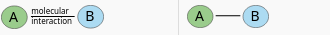

TODO : generate query with instances of bp3:Interaction ?

In [ ]:
query_interacts_with = """  

"""

#### 8 - Neighbor Of 
Proteins are participants or controlers of the same interaction

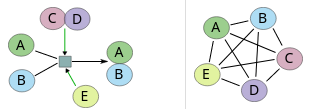

TO DO : fix bugs

In [ ]:
query_neighbor_of = """ 
CONSTRUCT {
  ?Protein1 abstraction:NeighborOf ?Protein2
}
WHERE {
  ?interaction (rdf:type/rdfs:subClassOf*) bp3:Interaction .
  
  VALUES ?interactingProperties { 
    bp3:participant
    bp3:left
    bp3:right
  }
  
  ?interaction ?interactingProperties ?interactor1 .
  ?interaction ?interactingProperties ?interactor2 .
  
  OPTIONAL {
    ?control (rdf:type/rdfs:subClassOf*) bp3:Control .
    ?control bp3:controlled ?interaction .
    ?control bp3:controller ?controllingEntity .
  }
  
  {
    ?interactor1 rdf:type bp3:Protein .
    BIND (?interactor1 AS ?Protein1)
  } UNION {
    ?interactor1 rdf:type bp3:Complex .
    ?interactor1 (bp3:component+|bp3:memberPhysicalEntity+)* ?interactor1Compo .
    ?interactor1Compo rdf:type bp3:Protein .
    BIND (?interactor1Compo AS ?Protein1)
  }
  
  {
    ?interactor2 rdf:type bp3:Protein .
    BIND (?interactor2 AS ?Protein2)
  } UNION {
    ?interactor2 rdf:type bp3:Complex .
    ?interactor2 (bp3:component+|bp3:memberPhysicalEntity+)* ?interactor2Compo .
    ?interactor2Compo rdf:type bp3:Protein .
    BIND (?interactor2Compo AS ?Protein2)
  } UNION {
    ?controllingEntity rdf:type bp3:Protein .
    BIND (?controllingEntity AS ?Protein2)
  } UNION {
    ?controllingEntity rdf:type bp3:Complex .
    ?controllingEntity (bp3:component+|bp3:memberPhysicalEntity+)* ?controllingEntityCompo .
    ?controllingEntityCompo rdf:type bp3:Protein .
    BIND (?controllingEntityCompo AS ?Protein2)
  } UNION {
    ?controllingEntity rdf:type bp3:PhysicalEntity .
    ?controllingEntity (bp3:memberPhysicalEntity*)/(bp3:component+|bp3:memberPhysicalEntity+)* ?controllingEntityCompo .
    ?controllingEntityCompo rdf:type bp3:Protein .
    BIND (?controllingEntityCompo AS ?Protein2)
  }
  
  FILTER (?Protein1 != ?Protein2)
}
"""

#### 9 - Consumption controled by
The small molecule is consumed by a reaction that is controled by a protein 

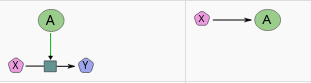


In [ ]:
query_consumption_controled_by = """  
CONSTRUCT {
  ?reactant abstraction:ConsumptionControlledBy ?controllingProtein 
}
WHERE {
  ?biochemicalReaction rdf:type bp3:BiochemicalReaction .
  ?reactant rdf:type bp3:SmallMolecule .
  ?product rdf:type bp3:SmallMolecule .
  ?reactant bp3:displayName ?reactantName .
  
  ?biochemicalReaction bp3:left ?reactant .
  ?biochemicalReaction bp3:right ?product .
  ?control bp3:controlled ?biochemicalReaction .
  ?control bp3:controller ?controllingEntity .
  
  {
   ?controllingEntity rdf:type bp3:Protein .
    BIND (?controllingEntity AS ?controllingProtein)
  } UNION
  {
    ?controllingEntity rdf:type bp3:Complex .
    ?controllingEntity (bp3:component+|bp3:memberPhysicalEntity+)* ?controllingEntityCompo .
    ?controllingEntityCompo rdf:type bp3:Protein .
    BIND (?controllingEntityCompo AS ?controllingProtein)
  } UNION 
  {
    ?controllingEntity rdf:type bp3:PhysicalEntity .
    ?controllingEntity (bp3:memberPhysicalEntity*)/(bp3:component+|bp3:memberPhysicalEntity+)* ?controllingEntityCompo .
    ?controllingEntityCompo rdf:type bp3:Protein .
    BIND (?controllingEntityCompo AS ?controllingProtein)
  }
    
  ?controllingProtein bp3:displayName ?controllingProteinName .
}
"""

#### 10 - Controls Production 
The protein controls a reaction of which the small molecule is an output

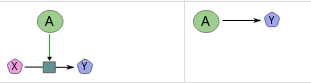

In [ ]:
query_controls_production = """ 
CONSTRUCT {
  ?controllingProtein abstraction:ControlsProductionOf ?product 
}
WHERE {
  ?biochemicalReaction rdf:type bp3:BiochemicalReaction .
  ?reactant rdf:type bp3:SmallMolecule .
  ?product rdf:type bp3:SmallMolecule .
  ?reactant bp3:displayName ?reactantName .
  
  ?biochemicalReaction bp3:left ?reactant .
  ?biochemicalReaction bp3:right ?product .
  ?control bp3:controlled ?biochemicalReaction .
  ?control bp3:controller ?controllingEntity .
  
  {
   ?controllingEntity rdf:type bp3:Protein .
    BIND (?controllingEntity AS ?controllingProtein)
  } UNION
  {
    ?controllingEntity rdf:type bp3:Complex .
    ?controllingEntity (bp3:component+|bp3:memberPhysicalEntity+)* ?controllingEntityCompo .
    ?controllingEntityCompo rdf:type bp3:Protein .
    BIND (?controllingEntityCompo AS ?controllingProtein)
  } UNION 
  {
    ?controllingEntity rdf:type bp3:PhysicalEntity .
    ?controllingEntity (bp3:memberPhysicalEntity*)/(bp3:component+|bp3:memberPhysicalEntity+)* ?controllingEntityCompo .
    ?controllingEntityCompo rdf:type bp3:Protein .
    BIND (?controllingEntityCompo AS ?controllingProtein)
  }
    
  ?controllingProtein bp3:displayName ?controllingProteinName .
}
"""

#### 11 - Controls Transport Of Chemical
The protein controls a reaction that changes the cellular location of the small molecule

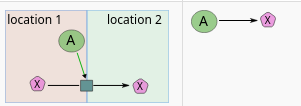

TODO : link with SmallMoleculeReferences

In [ ]:
query_controls_transport_of_chemical = """ 
CONSTRUCT {
  ?controllingProtein abstraction:ControlsTransportOfChemical ?SmallMolecule1Ref
}
WHERE {
  ?SmallMolecule1 rdf:type bp3:SmallMolecule ;
            bp3:displayName ?SmallMolecule1Name ;
            bp3:cellularLocation ?cellularLocVocab1 .
  ?SmallMolecule2 rdf:type bp3:SmallMolecule ;
            bp3:displayName ?SmallMolecule2Name  ;
            bp3:cellularLocation ?cellularLocVocab2 .
  
  ?SmallMolecule1 bp3:entityReference ?SmallMolecule1Ref .
  ?SmallMolecule2 bp3:entityReference ?SmallMolecule2Ref .
  ?cellularLocVocab1 bp3:term ?location1 .
  ?cellularLocVocab2 bp3:term ?location2 .

  ?biochemicalReaction rdf:type bp3:BiochemicalReaction ;
                       bp3:left ?SmallMolecule1 ;
                       bp3:right ?SmallMolecule2 .

  ?control (rdf:type/rdfs:subClassOf*) bp3:Control .
  ?control bp3:controlled ?biochemicalReaction .
  ?control bp3:controller ?controllingEntity .
  
  {
    ?controllingEntity rdf:type bp3:Protein .
    BIND (?controllingEntity AS ?controllingProtein)
  } UNION {
    ?controllingEntity rdf:type bp3:Complex .
    ?controllingEntity (bp3:component+|bp3:memberPhysicalEntity+)* ?controllingEntityCompo .
    ?controllingEntityCompo rdf:type bp3:Protein .
    BIND (?controllingEntityCompo AS ?controllingProtein)
  } UNION {
    ?controllingEntity rdf:type bp3:PhysicalEntity .
    ?controllingEntity (bp3:memberPhysicalEntity*)/(bp3:component+|bp3:memberPhysicalEntity+)* ?controllingEntityCompo .
    ?controllingEntityCompo rdf:type bp3:Protein .
    BIND (?controllingEntityCompo AS ?controllingProtein)
  }

  FILTER (?cellularLocVocab1 != ?cellularLocVocab2)
  FILTER (?SmallMolecule1Ref = ?SmallMolecule2Ref)
}
"""

#### 12 - Chemical Affects
A small molecule has an effect on the protein state

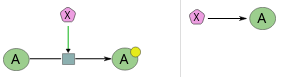


In [ ]:
query_chemical_affects = """  

"""

#### 13 - Reacts With
Small molecules are input to a biochemical reaction 

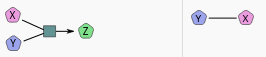

In [ ]:
query_reacts_with = """ 
CONSTRUCT {
  ?smallMolecule1 abstraction:reactsWith ?smallMolecule2 .
  ?smallMolecule2 abstraction:reactsWith ?smallMolecule1 .
}
WHERE {
  
  ?smallMolecule1 rdf:type bp3:SmallMolecule .
  ?smallMolecule2 rdf:type bp3:SmallMolecule .
  ?smallMolecule3 rdf:type bp3:SmallMolecule .
  
  ?biochemicalReaction bp3:left ?smallMolecule1 .
  ?biochemicalReaction bp3:left ?smallMolecule2 .
  ?biochemicalReaction bp3:right ?smallMolecule3 .
  ?biochemicalReaction rdf:type bp3:BiochemicalReaction .
  
  FILTER (?smallMolecule1 != ?smallMolecule2)
}
"""

#### 14 - Used To Produce
A reaction consumes a small molecule to produce another small molecule

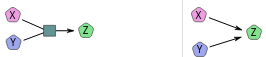

In [ ]:
query_used_to_produce = """ 
CONSTRUCT {
  ?smallMolecule1 abstraction:usedToProduce ?smallMolecule3 .
  ?smallMolecule2 abstraction:usedToProduce ?smallMolecule3 .
}
WHERE {
  
  ?smallMolecule1 rdf:type bp3:SmallMolecule .
  ?smallMolecule2 rdf:type bp3:SmallMolecule .
  ?smallMolecule3 rdf:type bp3:SmallMolecule .
  
  ?biochemicalReaction bp3:left ?smallMolecule1 .
  ?biochemicalReaction bp3:left ?smallMolecule2 .
  ?biochemicalReaction bp3:right ?smallMolecule3 .
  ?biochemicalReaction rdf:type bp3:BiochemicalReaction .
  
  FILTER (?smallMolecule1 != ?smallMolecule3)
  FILTER (?smallMolecule2 != ?smallMolecule3)
}
"""

In [65]:
# end process
process.kill()
time.sleep(60)